# Environment Setup

To ensure the environment is correctly set up, follow these steps to download the dataset and install any necessary non-standard libraries.

## Libraries Set Up

In [ ]:
 ! pip install -q kaggle

In [ ]:
! pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


## Dataset Set Up


In [ ]:
kaggle_json = {"username": "yijuli52", "key": "fe29da176c7e73aa458e22be06340fe45"}

import json
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_json, file)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d anirudhcv/labeled-optical-coherence-tomography-oct

Dataset URL: https://www.kaggle.com/datasets/anirudhcv/labeled-optical-coherence-tomography-oct
License(s): unknown
100% 6.70G/6.70G [07:20<00:00, 16.3MB/s]
100% 6.70G/6.70G [07:20<00:00, 16.3MB/s]


In [ ]:
!unzip labeled-optical-coherence-tomography-oct.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-15.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-16.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-18.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-2.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5822041-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-7.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-582215-8.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-1.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5823731-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-5.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5824080-6.jpeg  
  inflating: Dataset - train+val+test/val/NORMAL/NORMAL-5830194-10.jpeg  

# Data Exploration

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import seaborn as sns

In [ ]:
dataset_path = '/content/Dataset - train+val+test'

## About the Dataset: Classes

Number of images: 109309
Number of classes: 4
Class distribution: Counter({'NORMAL': 51390, 'CNV': 37455, 'DME': 11598, 'DRUSEN': 8866})


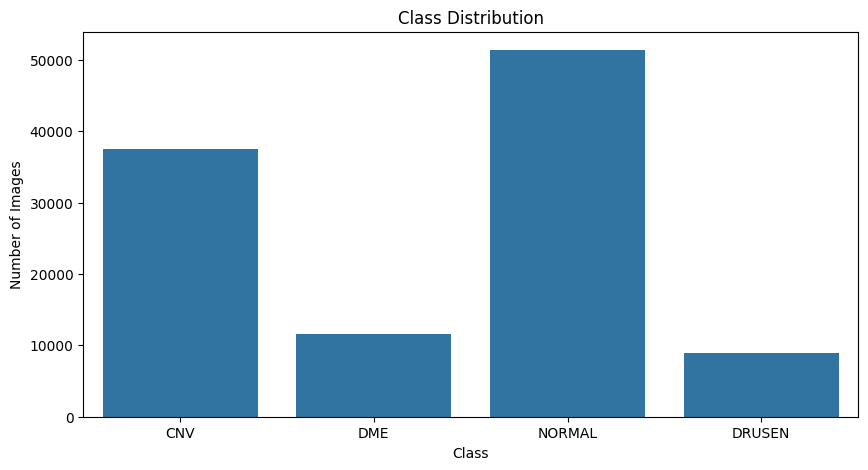

In [ ]:
def get_image_paths_and_labels(dataset_path):
    image_paths = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.jpeg'):
                image_paths.append(os.path.join(root, file))
                labels.append(root.split(os.path.sep)[-1])
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(dataset_path)

num_images = len(image_paths)
num_classes = len(set(labels))

print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

class_distribution = Counter(labels)
print(f"Class distribution: {class_distribution}")

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

## About the Dataset: Examples

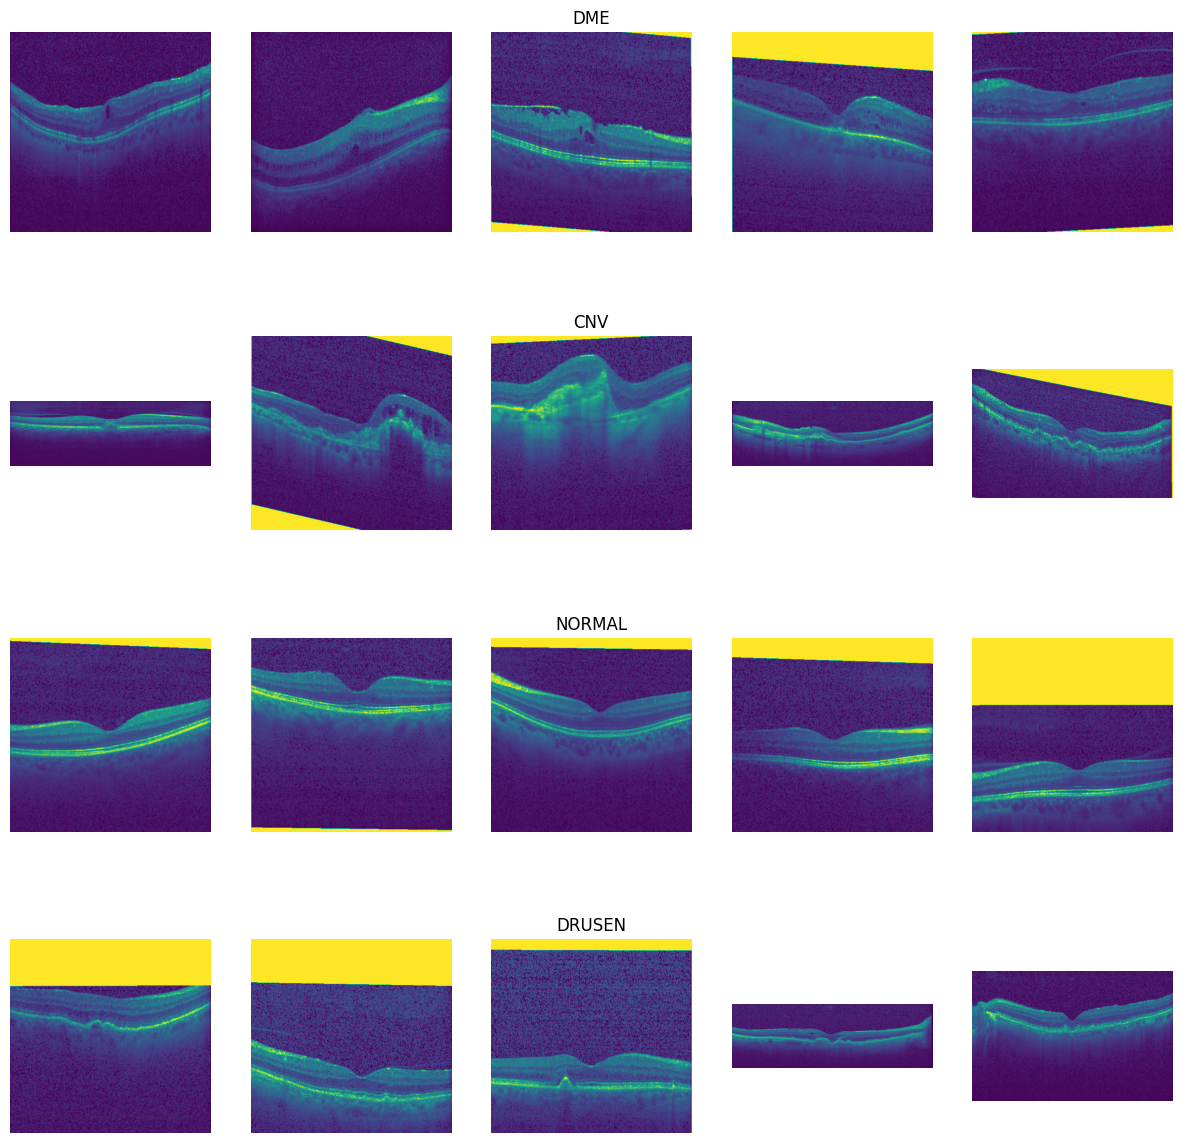

In [ ]:
def plot_example_images(image_paths, labels, class_distribution, num_examples=5):
    plt.figure(figsize=(15, 15))
    for i, cls in enumerate(class_distribution.keys()):
        cls_images = [image_paths[j] for j in range(len(image_paths)) if labels[j] == cls]
        for j in range(num_examples):
            img = Image.open(cls_images[j])
            plt.subplot(len(class_distribution), num_examples, i * num_examples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == num_examples // 2:
                plt.title(cls)
    plt.show()

plot_example_images(image_paths, labels, class_distribution)

In [ ]:
image_sizes = [Image.open(img_path).size for img_path in image_paths]

Image size distribution:
Size: (512, 512), Count: 8659
Size: (512, 496), Count: 58037
Size: (768, 496), Count: 29749
Size: (1536, 496), Count: 11512
Size: (1024, 496), Count: 1329
Size: (384, 496), Count: 21
Size: (900, 455), Count: 1
Size: (642, 277), Count: 1


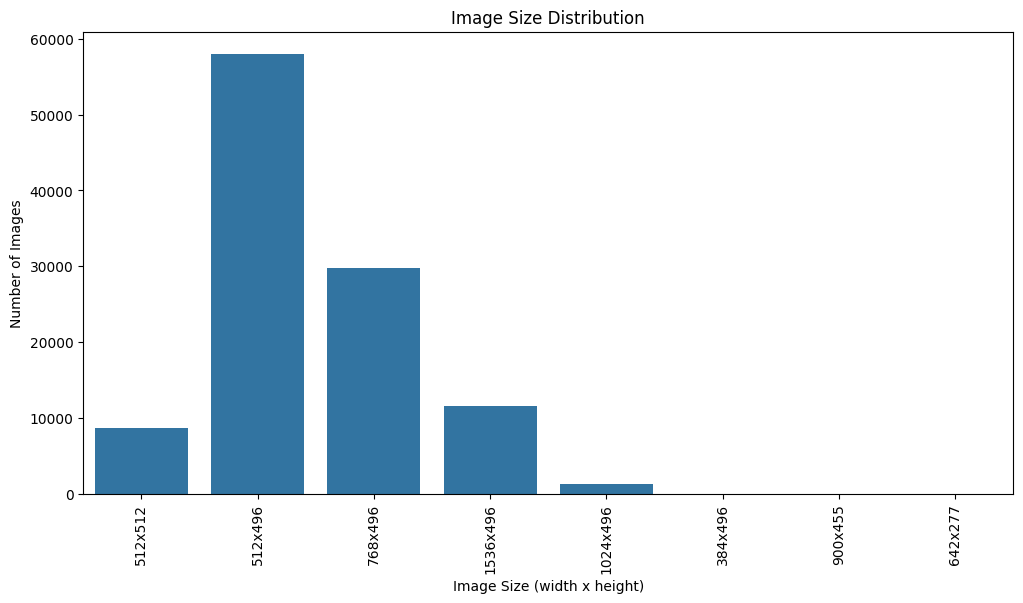

In [ ]:
size_distribution = Counter(image_sizes)

print("Image size distribution:")
for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

plt.figure(figsize=(12, 6))
sizes, counts = zip(*size_distribution.items())
sizes = [f"{size[0]}x{size[1]}" for size in sizes]
sns.barplot(x=sizes, y=counts)
plt.title('Image Size Distribution')
plt.xlabel('Image Size (width x height)')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

## Crop

In [ ]:
from tqdm import tqdm
import tensorflow as tf

def crop_center(img, cropx, cropy):
    y, x = img.shape[0], img.shape[1]
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

target_size = (496, 496)

def preprocess_images(image_paths, target_size):
    for img_path in tqdm(image_paths, desc="Processing images"):
        img = Image.open(img_path)
        img = np.array(img)
        img = crop_center(img, *target_size)
        img = Image.fromarray(img)
        img.save(img_path)

preprocess_images(image_paths, target_size)


Processing images: 100%|██████████| 109309/109309 [08:15<00:00, 220.66it/s]


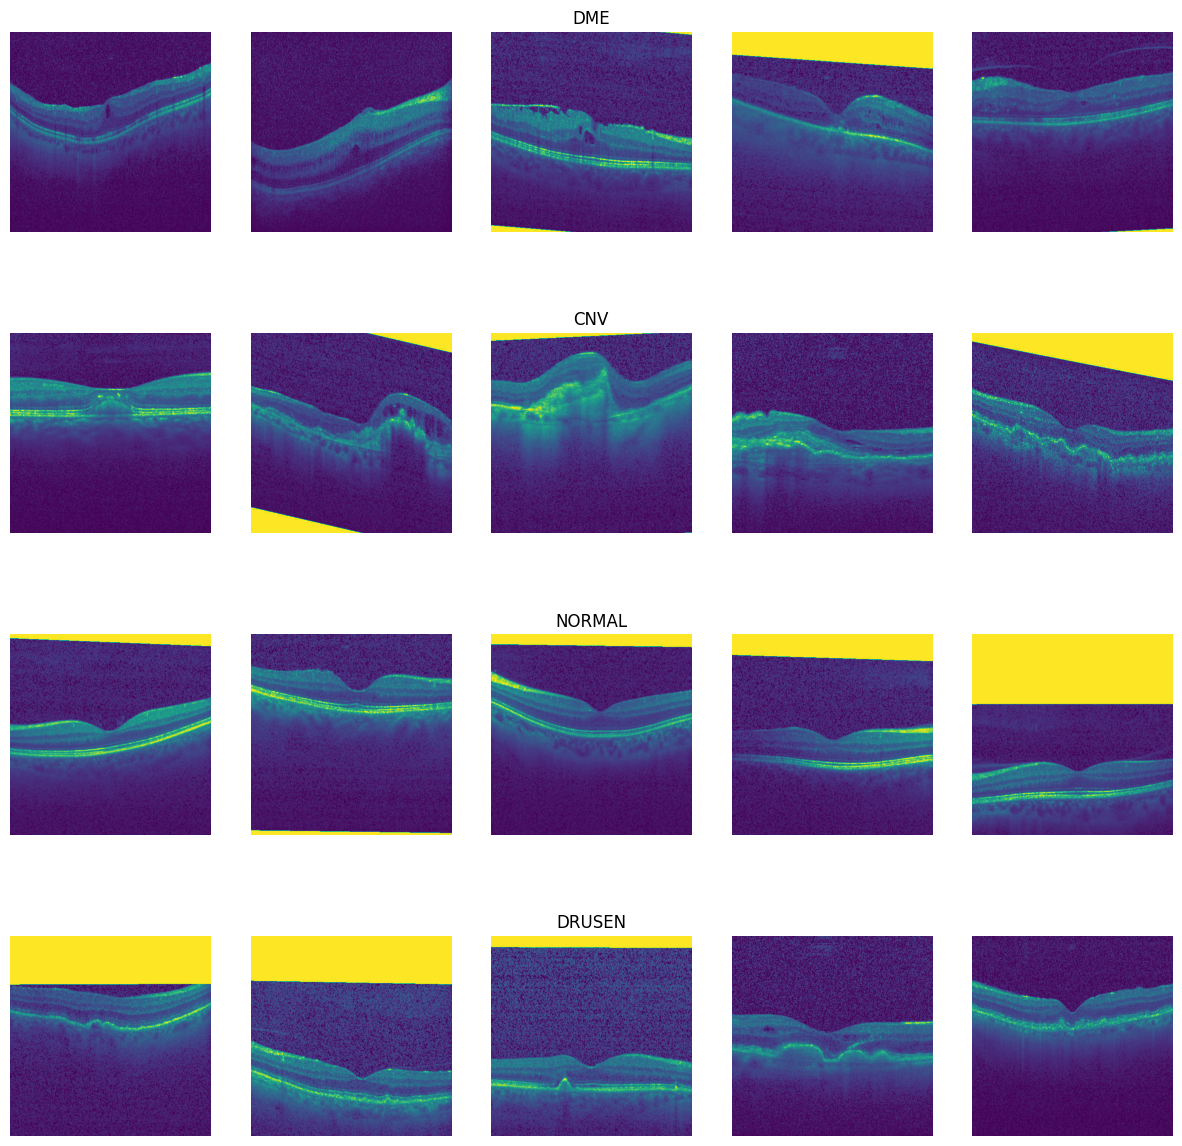

In [ ]:
plot_example_images(image_paths, labels, class_distribution)

## Convert to Tensor

In [11]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

def load_data(directory):
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow = data_gen.flow_from_directory(
        directory,
        target_size=(496, 496),
        color_mode='grayscale',
        batch_size=32,
        class_mode='sparse'
    )

    images, labels = [], []
    for img_batch, label_batch in data_flow:
        for img, label in zip(img_batch, label_batch):
            images.append(img)
            labels.append(label)
        break

    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

In [12]:
train_images, train_labels = load_data('/content/Dataset - train+val+test/train')

Found 76515 images belonging to 4 classes.


In [ ]:
train_images.shape

TensorShape([32, 496, 496, 1])

In [17]:
val_images, val_labels = load_data('/content/Dataset - train+val+test/val')
test_images, test_labels = load_data('/content/Dataset - train+val+test/test')

Found 21861 images belonging to 4 classes.
Found 10933 images belonging to 4 classes.


# Train

## Model #1: Simple CNNs

In [31]:
def create_model_1():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(496, 496, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_1 = create_model_1()

with tf.device('/GPU:0'):
    history = model_1.fit(
        train_images, train_labels,
        epochs=20,
        validation_data=(test_images, test_labels)
)

## Model #2: More CNN Layers


In [ ]:
def create_model_2():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(496, 496, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model_2 = create_model_2()

In [ ]:
if len(train_images.shape) == 4 and len(train_labels.shape) == 1:
    with tf.device('/GPU:0'):
        history_2 = model_2.fit(
            train_images, train_labels,
            epochs=20,
            validation_data=(test_images, test_labels)
        )
else:
    print("Error: The shape of your data is incorrect.")

## Model#3: More CNNs w/ Dropout and Normalization

In [ ]:
def create_model_3():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(496, 496, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_3 = create_model_3()

with tf.device('/GPU:0'):
    history_3 = model_3.fit(
        train_images, train_labels,
        epochs=100,
        validation_data=(test_images, test_labels)
    )

# Evaluations

In [118]:
def evaluate_model(model, input_images, input_labels, test_images, test_labels):
    loss, accuracy = model.evaluate(test_images, test_labels)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
        true_classes = np.argmax(test_labels, axis=1)
    else:
        true_classes = test_labels

    class_report = classification_report(true_classes, predicted_classes)
    print("Classification Report:")
    print(class_report)

    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    class_metrics = precision_recall_fscore_support(true_classes, predicted_classes)
    labels = np.unique(true_classes)

    plt.figure(figsize=(15, 5))
    plt.bar(labels - 0.2, class_metrics[0], 0.2, label='Precision')
    plt.bar(labels, class_metrics[1], 0.2, label='Recall')
    plt.bar(labels + 0.2, class_metrics[2], 0.2, label='F1-Score')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1-Score for each class')
    plt.legend()
    plt.show()

    num_images_to_show = 5
    indices = np.random.choice(len(test_images), num_images_to_show)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(test_images[idx], cmap='gray')
        plt.title(f"True: {true_classes[idx]}, Pred: {predicted_classes[idx]}")
        plt.axis('off')
    plt.show()

## Eval on Model 1

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.3735 - loss: 5.6219
Test Loss: 5.764761447906494
Test Accuracy: 0.35749998688697815
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41       200
           1       0.43      0.37      0.40       200
           2       0.38      0.32      0.35       200
           3       0.26      0.31      0.28       200

    accuracy                           0.36       800
   macro avg       0.36      0.36      0.36       800
weighted avg       0.36      0.36      0.36       800



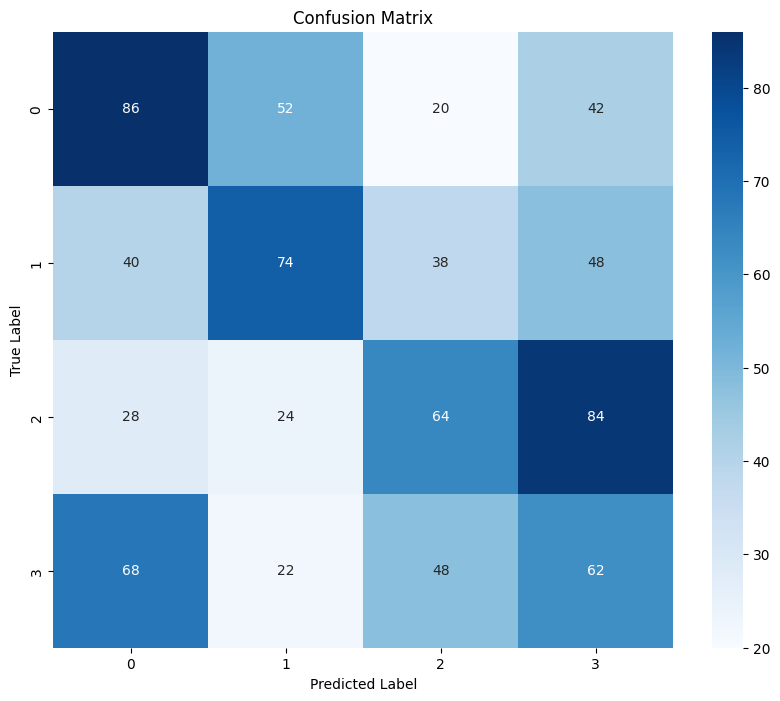

Precision: 0.36420059954224904
Recall: 0.3575
F1-Score: 0.3589455041062334


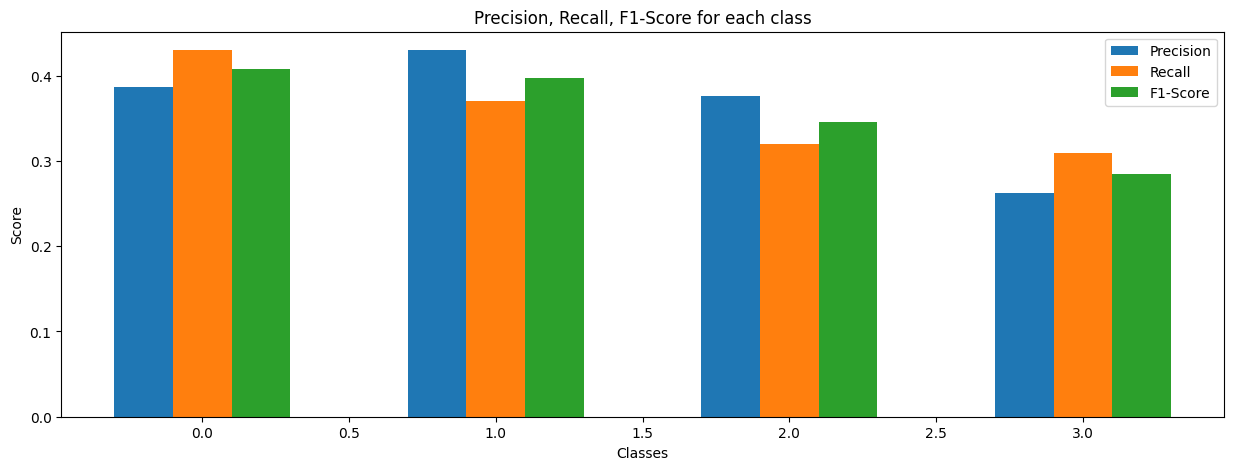

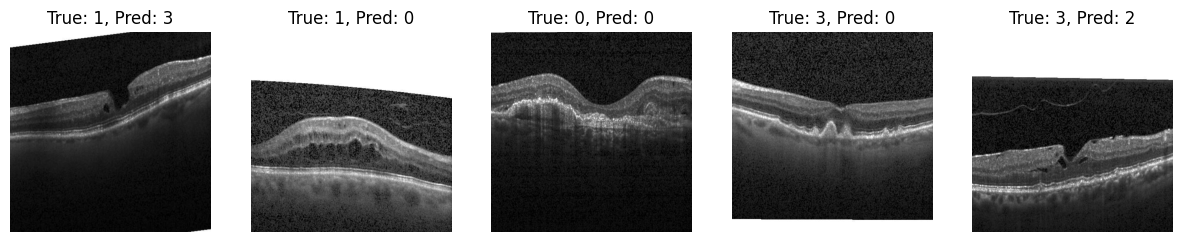

In [127]:
evaluate_model(model_1, train_images, train_labels,test_images,test_labels)

## Eval on Model 2

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6697 - loss: 2.9893
Test Loss: 2.8825948238372803
Test Accuracy: 0.6787499785423279
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       200
           1       0.74      0.69      0.71       200
           2       0.71      0.66      0.69       200
           3       0.60      0.66      0.63       200

    accuracy                           0.68       800
   macro avg       0.68      0.68      0.68       800
weighted avg       0.68      0.68      0.68       800



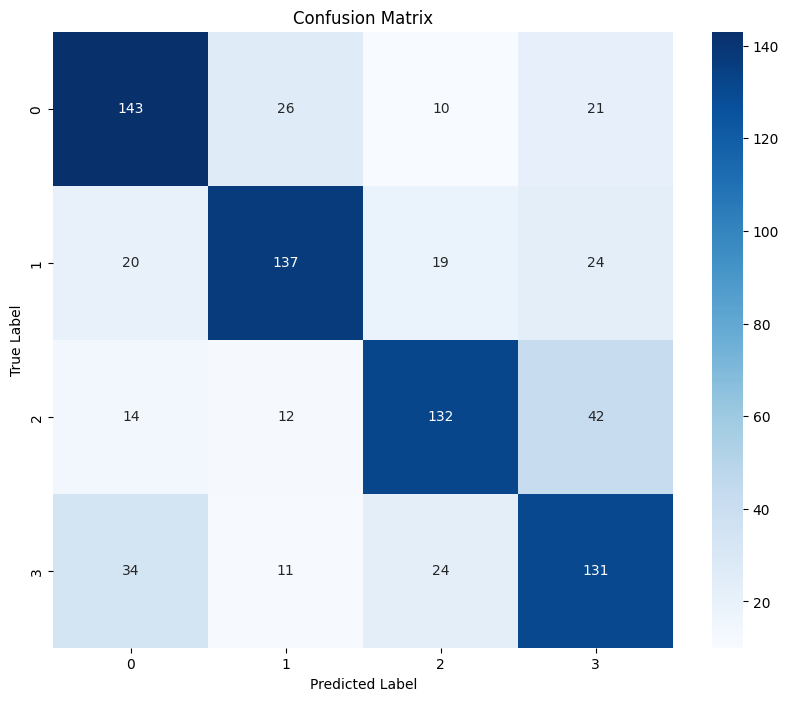

Precision: 0.6821788007436331
Recall: 0.67875
F1-Score: 0.6795542126579054


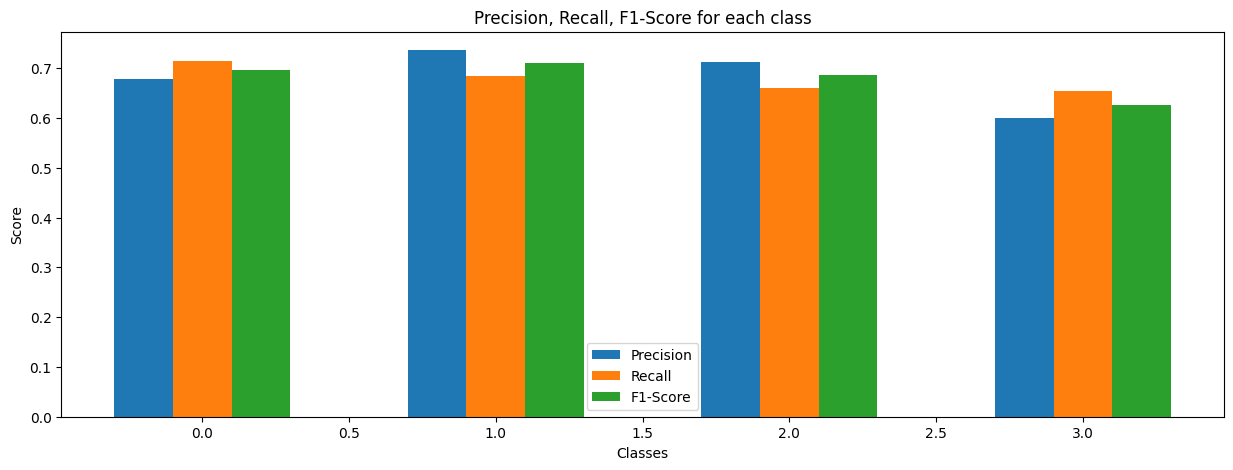

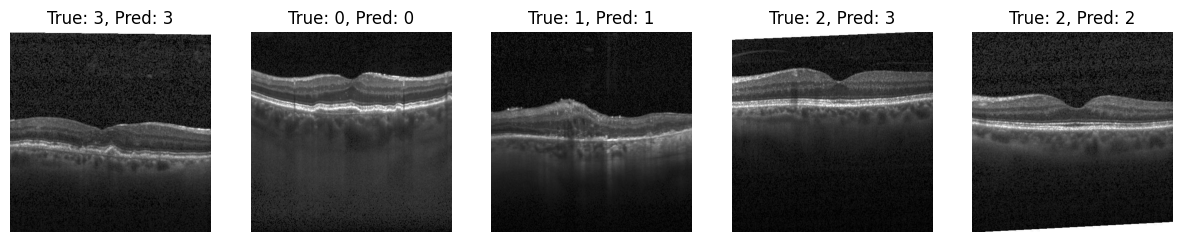

In [129]:
evaluate_model(model_2, train_images, train_labels,test_images,test_labels)

## Eval on Model 3

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8679 - loss: 1.0810
Test Loss: 1.232494592666626
Test Accuracy: 0.8500000238418579
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       200
           1       0.90      0.79      0.84       200
           2       0.78      1.00      0.87       200
           3       0.69      1.00      0.82       200

    accuracy                           0.85       800
   macro avg       0.82      0.90      0.85       800
weighted avg       0.87      0.85      0.85       800



Precision: 0.8675167677457584
Recall: 0.85
F1-Score: 0.8506427383444166


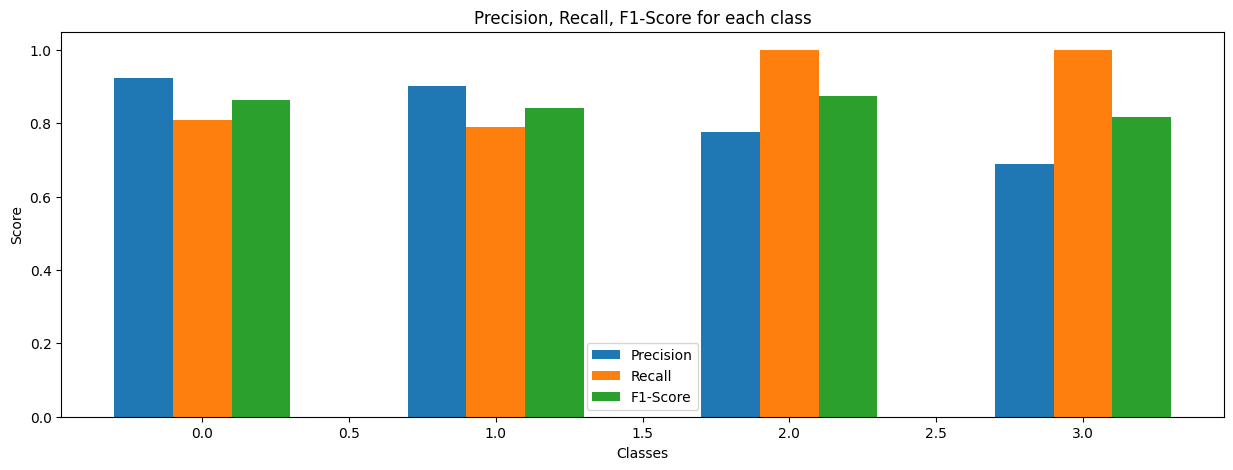

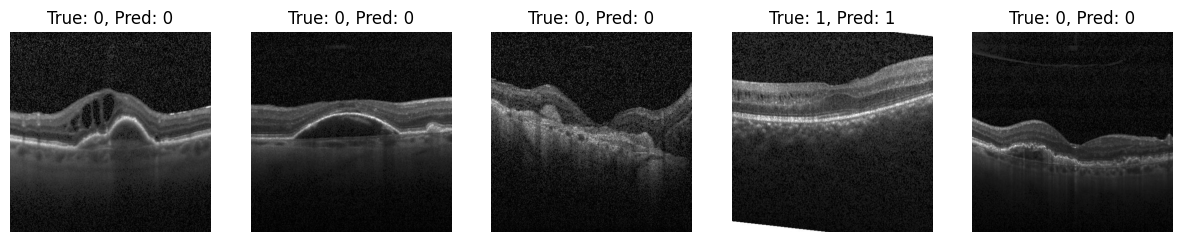

In [132]:
evaluate_model(model_3, train_images, train_labels,test_images,test_labels)